# thal2 2:1 Bifurcation Diagrams

# Inits

## Imports

In [1]:
import sys; sys.path.insert(0, '..') # add parent folder path where lib folder is
# user-defined
import nmCoupling as nm
# import nmCoupling_old as nm
import response as rp

import thal2 as t2

from lib.util import (get_phase, freq_est,follow_phase_diffs,follow_phase_diffs_del,
                        follow_phase_diffs_u,follow_phase_diffs_u_del,
get_smallest_eps,get_largest_eps, get_es_min, get_es_max,follow_phase_diffs_v2)

from lib.rhs import _redu_c2,_full, _redu_full, _full, _full_mono_rhs

from lib.plot_util import (add_diagram_1d_scatter, quick_plot_combined, 
                            draw_quick_plot_f, add_diagram_1d_del_scatter)


import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import sympy as sym

from scipy.signal import find_peaks
from scipy.optimize import root,bisect
from copy import deepcopy
import os

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})

nmc = nm.nmCoupling
rsp = rp.Response

## Dicts

In [2]:
kw_sim = {'rtol':1e-9,'atol':1e-9,'method':'LSODA'}

In [3]:
pd1 = {'gL':0.05,'gna':3,'gk':5,
       'gt':5,'eL':-70,'ena':50,
       'ek':-90,'et':0,'esyn':0,
       'c':1,'alpha':3,'beta':2,
       'sigmat':0.8,'vt':-20,
       'ib':8.5,'del':0,'om':1,'om_fix':1}

In [4]:
# default period must be 2*np.pi
kws1 = {'var_names':['v','h','r','w'],
        'pardict':pd1,
        'rhs':t2.rhs,
        'coupling':t2.coupling,
        'init':np.array([-.64,0.71,0.25,0,6]),
        'TN':20000,
        'trunc_order':1,
        'z_forward':False,
        'i_forward':[False,True,False,False,False,False],
        'i_bad_dx':[False,True,False,False,False,False],
        'max_iter':50,
        'rtol':1e-12,
        'atol':1e-12,
        'rel_tol':1e-9,
        'save_fig':False,
        'lc_prominence':.05,
        'factor':1}

## Defs

In [5]:
#### es_min,phi0 = get_es_min(data_bs_list,data_bu_list)
def get_monodromy_full(es_min,phi0,a,b,mname='',tol=1e-6,recompute=False,max_time=10000):
    """
    es_min: minimum epsilon to use
    a: nmCoupling object
    b: het. parameter.
    mnamei are the model names to save the monodromy matrix and related calculations
    """    

    kw_b = {'a':a,'b':b,'recompute':recompute,'bifdir':'bif1d_thal2/','_full_rhs':_full}
    print('es_min,phi0',es_min,phi0)
    # the _u function has the ability to save and load Y values
    _,Y = follow_phase_diffs(**dict(phi0=phi0,eps_init=es_min,eps_final=es_min-.01,deps=-1),max_time=max_time,tol=tol,return_point=True,**kw_b)

    print('Y',Y)
    # define parameters for finding monodromy of full system
    pd_vdp_thal = {**a.system1.pardict,**a.system2.pardict}
    pd_vdp_thal['b']=b
    pd_vdp_thal['a']=a
    
    pd_vdp_thal['eps']=es_min
    # print(pd1['del0'])
    
    # default period must be 2*np.pi
    kws_vdp_thal = {'var_names':['v0','h0','r0','w0','v1','h1','r1','w1'],
                    'pardict':pd_vdp_thal,
                    'rhs':_full_mono_rhs,
                    'coupling':lambda x: 0*x,
                    'init':Y, # from above
                    'use_init':True, # use init for direct LC calculation
                    'TN':50000,
                    'mode':'none', # forces not normalizing period.
                    'rtol_lc':1e-10,
                    'atol_lc':1e-10,
                    'trunc_order':0,
                    'z_forward':False,
                    'i_forward':False,
                    'i_bad_dx':[False,True,False,False,False,False],
                    'save_fig':False,
                    'max_iter':50,
                    'max_time_lc':5000,
                    'tol_root_lc':1e-8,
                    'halt_after_mono':True}

    m1 = rsp(idx='',model_name=mname,**kws_vdp_thal)

    return m1

In [6]:
kw_bif = {'method':'LSODA','dense_output':True,'rtol':1e-9,'atol':1e-9}

In [7]:
x_temp = np.linspace(-np.pi,3*np.pi,500)

In [8]:
ss,dss=np.linspace(0,2,100,retstep=True)

In [9]:
def compute_sol_all(a,eps,phi0,b,T=2000,dt=.01):
    """
    only for use in jupyter
    """
    t = np.arange(0,T,dt)
    args = {'args':(a,eps,b), 't_eval':t,**kw_sim}

    y0a = a.system1.lc['dat'][int((phi0/(2*np.pi)) * a.system1.TN),:]
    y0b = a.system2.lc['dat'][int((0/(2*np.pi)) * a.system2.TN),:]
    y0 = np.array([y0a,y0b]).flatten()
    #a.system1.pardict['del0'] = b

    tot = 0
    for i in range(len(a.het_coeffs)):
        tot += eps**i*b**(i+1)*a.het_coeffs[i]
    a.system1.pardict['del0'] = tot
    print(a.system1.pardict['del0'])
    #print(pd1['del0'])
    
    solf = solve_ivp(_full,[0,t[-1]], y0, **args)

    args['args'] = (a,eps,b,1)
    solr_o1 = solve_ivp(_redu_c2,[0,t[-1]], [phi0],**args)
    
    args['args'] = (a,eps,b,2)
    solr_o2 = solve_ivp(_redu_c2,[0,t[-1]], [phi0],**args)
    
    #args['args'] = (a,eps,b,3)
    #solr_o3 = solve_ivp(_redu_c2,[0,t[-1]], [phi0],**args)
    
    #args['args'] = (a,eps,b,4)
    #solr_o4 = solve_ivp(_redu_c2,[0,t[-1]], [phi0],**args)

    return solf, solr_o1, solr_o2#, solr_o3, solr_o4


def load_sol_all(a,eps,phi0,b,T,dt=.01,path_loc='sols_temp/',recompute=True):
    if (not os.path.exists(path_loc)):
        os.makedirs(path_loc)
    
    fname_f = 'sol_f_thal2_nm={}{}_eps={}_b={}_T={}_phi0={}.dat'.format(a._n[1],a._m[1],eps,b,T,phi0)
    fname_r = 'sol_r_thal2_nm={}{}_eps={}_b={}_T={}_phi0={}.dat'.format(a._n[1],a._m[1],eps,b,T,phi0)

    fname_f = path_loc + fname_f
    fname_r = path_loc + fname_r

    print('full',fname_f)
    print('redu',fname_r)
    
    file_dne = not(os.path.isfile(fname_f))
    file_dne += not(os.path.isfile(fname_r))

    if file_dne or recompute:
        solf, solr_o1, solr_o2 = compute_sol_all(a,eps,phi0,b,T=T,dt=dt)

        # phase of full model
        ta, pha = get_phase(solf.t,solf.y.T[:,:4], skipn=200,system1=a.system1)
        tb, phb = get_phase(solf.t,solf.y.T[:,4:], skipn=200,system1=a.system2)

        dat1 = np.zeros([len(ta),2])
        dat1[:,0] = ta
        dat1[:,1] = np.mod(pha - a.om*phb,2*np.pi)

        dat2 = np.zeros([len(solr_o1.t),5])
        dat2[:,0] = solr_o1.t
        dat2[:,1] = solr_o1.y[0]
        dat2[:,2] = solr_o2.y[0]

        np.savetxt(fname_f,dat1)
        np.savetxt(fname_r,dat2)

    else:
        dat1 = np.loadtxt(fname_f)
        dat2 = np.loadtxt(fname_r)
    return dat1, dat2

## Initialize Response Functions

In [10]:
system1 = rsp(idx=0,model_name='thal0_85',**kws1)
system2 = rsp(idx=1,model_name='thal1_85',**kws1)

mkdir ./data/thal0_85/
* Loading LC data...
self.T 6.283185307179586 omfix 0.990198152249508
self.T 6.283185307179586
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.024354475778909167
* Loading g symbolic...
* Computing g...
* Loading heterogeneous terms...
* Computing z...
* Computing i...
mkdir ./data/thal1_85/
* Loading LC data...
self.T 6.283185307179586 omfix 0.990198152249508
self.T 6.283185307179586
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.024354475778909167
* Loading g symbolic...
* Computing g...
* Loading heterogeneous terms...
* Computing z...
* Computing i...


# Initialize Coupling 2:1

In [11]:
het_coeffs = [1,100]

In [12]:
#recompute_list = ['k_thal0_85','k_thal1_85','h_thal0_85','h_thal1_85', 'h_data_thal0_85','h_data_thal1_85', 'p_data_thal0_85','p_data_thal1_85','p_thal0_85','p_thal1_85']
# recompute_list = ['k_thal0_85','k_thal1_85']
nm_tup = (2,1)
recompute_list = []
kw_nm = {'system1':system1,'system2':system2,'_n':('om0',nm_tup[0]),'_m':('om1',nm_tup[1]),
         'NH':1024,'save_fig':False, 'recompute_list':recompute_list,
         'het_coeffs':het_coeffs, # [eps, eps^2, etc]
        }
a = nm.nmCoupling(**kw_nm)
nm_val = str(nm_tup[0])+str(nm_tup[1])

Initializing 21 Coupling...
pfactor 30
* Loading p symbolic...
* Loading p symbolic...
p order=0
p order=0
* Loading H symbolic...
* Loading H symbolic...
* Loading H thal0_85, order=0...
* Loading H thal1_85, order=0...
* Loading H thal0_85, order=1...
* Loading H thal1_85, order=1...


### Plot 1par eps

In [13]:
etup = (.001,.2,100)

In [14]:
# fig,axs = plt.subplots(1,2,figsize=(6,2))
# kw_diagram = dict(a=a,b=-0.028,eps_tup=etup,rhs=_redu_c2)
# add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
# add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

In [15]:
# fig,axs = plt.subplots(1,2,figsize=(6,2))
# kw_diagram = dict(a=a,b=-.04,eps_tup=etup,rhs=_redu_c2)
# add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
# add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

<Axes: >

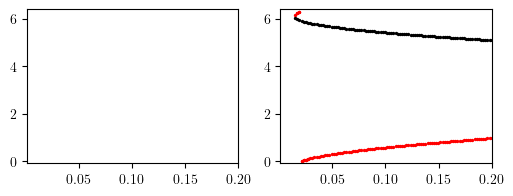

In [16]:
fig,axs = plt.subplots(1,2,figsize=(6,2))
kw_diagram = dict(a=a,b=-.035,eps_tup=etup,rhs=_redu_c2)
add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

### Plot 1par del

<Axes: >

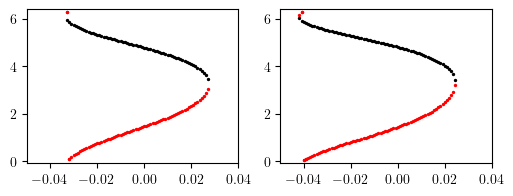

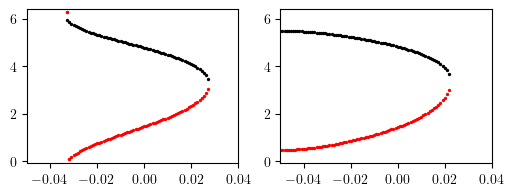

In [17]:
dtup12 = (-.05,.04,100)

fig,axs = plt.subplots(1,2,figsize=(6,2))
kw_diagram = dict(a=a,eps=0.05,del_tup=dtup12,rhs=_redu_c2)
add_diagram_1d_del_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_del_scatter(axs[1],miter=2,**kw_diagram)

fig,axs = plt.subplots(1,2,figsize=(6,2))
kw_diagram = dict(a=a,eps=0.1,del_tup=dtup12,rhs=_redu_c2)
add_diagram_1d_del_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_del_scatter(axs[1],miter=2,**kw_diagram)

#for i in range(4):
#    draw_quick_plot_f(axs[i],data_b1_list,a)

## EPS VARY

In [18]:
kw_b = {'a':a,'b':0,'recompute':False,'bifdir':'bif1d_thal2/','_full_rhs':_full}
fname_bs = kw_b['bifdir']+'hyper_thal2_'+nm_val+'_b={}_s.txt'
fname_bu = kw_b['bifdir']+'hyper_thal2_'+nm_val+'_b={}_u.txt'

In [19]:
mname_list = ['thal2_'+nm_val+'_b'+str(i)+'={}' for i in range(5)]

In [20]:
b_vals_full = []
e_vals_full = [] # save min eps values for all diagrams
e_hi_full = [] # save max eps values for all diagrams

## monodromy calculations
e_vals_mono_min = [] # save eps values at min monodromy
eigenvalues_min_all = []
b_min_all = []

e_vals_mono_max = [] # save eps values at max monodromy
eigenvalues_max_all = []
b_max_all = []

### b=.02

#### Sim

full sols_temp/sol_f_thal2_nm=21_eps=0.15_b=0.02_T=2000_phi0=2.dat
redu sols_temp/sol_r_thal2_nm=21_eps=0.15_b=0.02_T=2000_phi0=2.dat


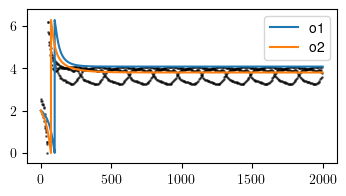

In [21]:
a=a;T=2000;b=0.02;e=.15;phi0 = 2
dat1,dat2=load_sol_all(a=a,eps=e,phi0=phi0,b=b,T=T,recompute=False)
t1=dat1[:,0];y=dat1[:,1]
t2=dat2[:,0];so1=dat2[:,1];so2=dat2[:,2]

fig,axs = plt.subplots(figsize=(4,2))

axs.scatter(t1,y,s=1,alpha=.5,color='black')

axs.plot(t2,np.mod(so1,2*np.pi),label='o1')
axs.plot(t2,np.mod(so2,2*np.pi),label='o2')

axs.set_ylim(-.5,2*np.pi+.5)
axs.legend()

#### Branches eps stable

In [22]:
b=.02
kw_b['recompute'] = False
kw_b['b'] = b

In [23]:
# in_dicts = [dict(phi0=phi0,eps_init=0.1,eps_final=0,deps=-.01) for phi0 in np.linspace(0,2*np.pi,20)]
in_dicts = [dict(phi0=5.5,eps_init=0.05,eps_final=0,deps=-.005),
            dict(phi0=5.5,eps_init=0.049,eps_final=0.2,deps=.005)]

In [24]:
data_bs_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_b)
    data_bs_list.append(dat)

phi init 5.5
phi init 5.5


In [25]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bs.format(b),hyp_inputs)

#### Branches eps unstable

In [26]:
kw_b['recompute'] = False
kw_b['b'] = b

In [27]:
# # get an initial condition for an unstable branch
# phis = np.linspace(5.8,6.1,30)
# for phi in phis:
#     dat,Yinit = follow_phase_diffs_u(**dict(phi0=phi,eps_init=0.02,eps_final=0,deps=-2),max_iter=100,return_point=True,**kw_b)

In [28]:
_,Yinit = follow_phase_diffs(**dict(phi0=1,eps_init=0.05,eps_final=0,deps=-2),c_sign=-1,max_iter=100,return_point=True,**kw_b)

phi init 1


In [29]:
#in_dicts = [dict(phi0=phi0,eps_init=0.01,eps_final=0.0,deps=-.01) for phi0 in np.linspace(4-1,4+1,10)]
in_dicts = [dict(phi0=.5,eps_init=0.05,eps_final=0,deps=-.001),
            dict(phi0=.5,eps_init=0.049,eps_final=0.2,deps=.01),
           ]

In [30]:
data_bu_list = []
# Y=Yinit
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(use_point=Yinit,c_sign=-1,**in1,**kw_b)
    data_bu_list.append(dat)

phi init 0.5
phi init 0.5


In [31]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bu.format(b),hyp_inputs)

#### Plot combined 1 par

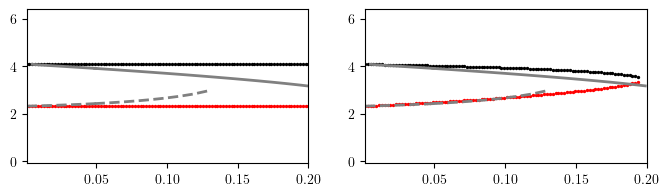

In [32]:
fig,axs = plt.subplots(1,2,figsize=(8,2))
kw_diagram = dict(a=a,b=b,eps_tup=etup,rhs=_redu_c2)
add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

for i in range(2):
    draw_quick_plot_f(axs[i],data_bs_list,a)
    draw_quick_plot_f(axs[i],data_bu_list,a,ls='--')

In [33]:
b_vals_full.append(b)

es = get_smallest_eps(data_bs_list)
eu = get_smallest_eps(data_bu_list)

e_vals_full.append(np.min([es,eu]))

es = get_largest_eps(data_bs_list)
eu = get_largest_eps(data_bu_list)

e_hi_full.append(np.max([es,eu]))

### b=-0.028

#### Sim

In [34]:
# a=a;T=5000;b=0.007;e=.038;phi0 = 4
# dat1,dat2=load_sol_all(a=a,eps=e,phi0=phi0,b=b,T=T,recompute=False)
# t1=dat1[:,0];y=dat1[:,1]
# t2=dat2[:,0];so1=dat2[:,1];so2=dat2[:,2]

# fig,axs = plt.subplots(figsize=(4,2))

# axs.scatter(t1,y,s=1,alpha=.5,color='black')

# axs.plot(t2,np.mod(so1,2*np.pi),label='o1')
# axs.plot(t2,np.mod(so2,2*np.pi),label='o2')

# axs.set_ylim(-.5,2*np.pi+.5)
# axs.legend()

##### Original

In [35]:
# # show original system
# a=a;T=1000;b=0.007;e=.02;phi0 = 4
# solf, solr_o1, solr_o2 = compute_sol_all(a,e,phi0,b,T=T,dt=.01)

In [36]:
# fig,axs = plt.subplots(figsize=(4,2))
# axs.plot(solf.t,solf.y[0])
# # axs.plot(solf.t,solf.y[3])
# axs.plot(solf.t,solf.y[4])
# axs.set_xlim(800,1000)

#### Branches eps stable

In [37]:
b=-.028
kw_b['recompute'] = False
kw_b['b'] = b

In [38]:
# in_dicts = [dict(phi0=phi0,eps_init=0.1,eps_final=0,deps=-.01) for phi0 in np.linspace(0,2*np.pi,20)]
in_dicts = [dict(phi0=5.5,eps_init=0.05,eps_final=0,deps=-.005),
            dict(phi0=5.5,eps_init=0.049,eps_final=0.2,deps=.005)]

In [39]:
data_bs_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_b)
    data_bs_list.append(dat)

phi init 5.5
phi init 5.5


In [40]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bs.format(b),hyp_inputs)

#### Branches eps unstable

In [41]:
kw_b['recompute'] = False
kw_b['b'] = b

In [42]:
# # get an initial condition for an unstable branch
# phis = np.linspace(5.8,6.1,30)
# for phi in phis:
#     dat,Yinit = follow_phase_diffs_u(**dict(phi0=phi,eps_init=0.02,eps_final=0,deps=-2),max_iter=100,return_point=True,**kw_b)

In [43]:
_,Yinit = follow_phase_diffs(**dict(phi0=1,eps_init=0.05,eps_final=0,deps=-2),c_sign=-1,max_iter=100,return_point=True,**kw_b)

phi init 1


In [44]:
#in_dicts = [dict(phi0=phi0,eps_init=0.01,eps_final=0.0,deps=-.01) for phi0 in np.linspace(4-1,4+1,10)]
in_dicts = [dict(phi0=.5,eps_init=0.05,eps_final=0,deps=-.001),
            dict(phi0=.5,eps_init=0.049,eps_final=0.2,deps=.01),
           ]

In [45]:
data_bu_list = []
# Y=Yinit
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(use_point=Yinit,c_sign=-1,**in1,**kw_b)
    data_bu_list.append(dat)

phi init 0.5
phi init 0.5


In [46]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bu.format(b),hyp_inputs)

#### Plot combined 1 par

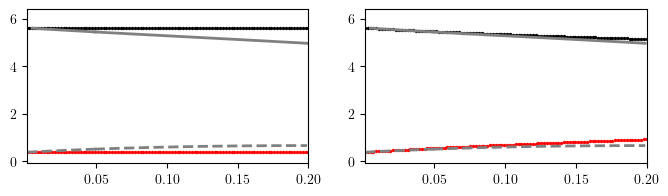

In [47]:
fig,axs = plt.subplots(1,2,figsize=(8,2))
kw_diagram = dict(a=a,b=b,eps_tup=etup,rhs=_redu_c2)
add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

for i in range(2):
    draw_quick_plot_f(axs[i],data_bs_list,a)
    draw_quick_plot_f(axs[i],data_bu_list,a,ls='--')

In [48]:
b_vals_full.append(b)

es = get_smallest_eps(data_bs_list)
eu = get_smallest_eps(data_bu_list)

e_vals_full.append(np.min([es,eu]))

es = get_largest_eps(data_bs_list)
eu = get_largest_eps(data_bu_list)

e_hi_full.append(np.max([es,eu]))

### b=-0.035

#### Branches eps stable

In [49]:
b=-.035
kw_b['recompute'] = False
kw_b['b'] = b

In [50]:
# in_dicts = [dict(phi0=phi0,eps_init=0.1,eps_final=0,deps=-.01) for phi0 in np.linspace(0,2*np.pi,20)]
in_dicts = [dict(phi0=1,eps_init=0.05,eps_final=0,deps=-.005),
            dict(phi0=1,eps_init=0.049,eps_final=0.2,deps=.005)]

In [51]:
data_bs_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_b)
    data_bs_list.append(dat)

phi init 1
phi init 1


In [52]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bs.format(b),hyp_inputs)

#### Branches eps unstable

In [53]:
kw_b['recompute'] = False
kw_b['b'] = -0.028
da,Yinit = follow_phase_diffs_u(**dict(phi0=1,eps_init=0.05,eps_final=0,deps=-2),c_sign=-1,max_iter=100,return_point=True,**kw_b)
print(da)

kw_b['b'] = -0.028
da,Yinit = follow_phase_diffs_u(**dict(phi0=1,eps_init=0.06,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)

kw_b['b'] = -0.0285
da,Yinit = follow_phase_diffs_u(**dict(phi0=1,eps_init=0.06,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)

kw_b['b'] = -0.029
da,Yinit = follow_phase_diffs_u(**dict(phi0=1,eps_init=0.06,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)

kw_b['b'] = -0.03
da,Yinit = follow_phase_diffs_u(**dict(phi0=1,eps_init=0.06,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)

kw_b['b'] = -0.032
da,Yinit = follow_phase_diffs_u(**dict(phi0=1,eps_init=0.06,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)

kw_b['b'] = -0.035
da,Yinit = follow_phase_diffs_u(**dict(phi0=1,eps_init=0.06,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)

phi init 1
phase_diffs_u_init=1_nm=21_b=-0.028_ei=0.05_ef=0_de=-2.txt
phase_diffs_u_pt_init=1_nm=21_b=-0.028_ei=0.05_ef=0_de=-2.txt
[0.05      3.1770937 0.5043161]
phi init 1
phase_diffs_u_init=1_nm=21_b=-0.028_ei=0.06_ef=0_de=-2.txt
phase_diffs_u_pt_init=1_nm=21_b=-0.028_ei=0.06_ef=0_de=-2.txt
[0.06       3.10309152 0.65605931]
phi init 1
phase_diffs_u_init=1_nm=21_b=-0.0285_ei=0.06_ef=0_de=-2.txt
phase_diffs_u_pt_init=1_nm=21_b=-0.0285_ei=0.06_ef=0_de=-2.txt
[0.06       3.10209149 0.63601553]
phi init 1
phase_diffs_u_init=1_nm=21_b=-0.029_ei=0.06_ef=0_de=-2.txt
phase_diffs_u_pt_init=1_nm=21_b=-0.029_ei=0.06_ef=0_de=-2.txt
[0.06       3.10309152 0.62771107]
phi init 1
phase_diffs_u_init=1_nm=21_b=-0.03_ei=0.06_ef=0_de=-2.txt
phase_diffs_u_pt_init=1_nm=21_b=-0.03_ei=0.06_ef=0_de=-2.txt
[0.06       3.10309152 0.59531308]
phi init 1
phase_diffs_u_init=1_nm=21_b=-0.032_ei=0.06_ef=0_de=-2.txt
phase_diffs_u_pt_init=1_nm=21_b=-0.032_ei=0.06_ef=0_de=-2.txt
[0.06       3.10209149 0.53473918]
p

In [54]:
#in_dicts = [dict(phi0=phi0,eps_init=0.01,eps_final=0.0,deps=-.01) for phi0 in np.linspace(4-1,4+1,10)]
in_dicts = [dict(phi0=6,eps_init=0.06,eps_final=0,deps=-.002),
            dict(phi0=6,eps_init=0.0599,eps_final=0.2,deps=.002),
           ]

In [55]:
data_bu_list = []
# Y=Yinit
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs_u(use_point=Yinit,**in1,**kw_b)
    data_bu_list.append(dat)

phi init 6
phase_diffs_u_init=6_nm=21_b=-0.035_ei=0.06_ef=0_de=-0.002.txt
phase_diffs_u_pt_init=6_nm=21_b=-0.035_ei=0.06_ef=0_de=-0.002.txt
phi init 6
phase_diffs_u_init=6_nm=21_b=-0.035_ei=0.0599_ef=0.2_de=0.002.txt
phase_diffs_u_pt_init=6_nm=21_b=-0.035_ei=0.0599_ef=0.2_de=0.002.txt


In [56]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bu.format(b),hyp_inputs)

#### Plot combined 1 par

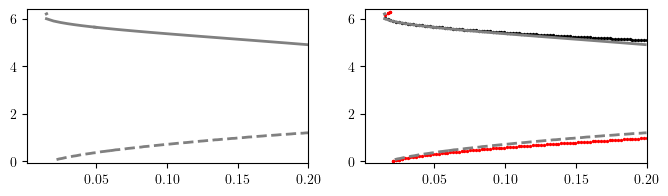

In [57]:
fig,axs = plt.subplots(1,2,figsize=(8,2))
kw_diagram = dict(a=a,b=b,eps_tup=etup,rhs=_redu_c2)
add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

for i in range(2):
    draw_quick_plot_f(axs[i],data_bs_list,a)
    draw_quick_plot_f(axs[i],data_bu_list,a,ls='--')

In [58]:
b_vals_full.append(b)

es = get_smallest_eps(data_bs_list)
eu = get_smallest_eps(data_bu_list)

e_vals_full.append(np.min([es,eu]))

es = get_largest_eps(data_bs_list)
eu = get_largest_eps(data_bu_list)

e_hi_full.append(np.max([es,eu]))

### b=-0.04

#### Branches eps stable

In [59]:
b=-.04
kw_b['recompute'] = False
kw_b['b'] = b

In [60]:
# in_dicts = [dict(phi0=phi0,eps_init=0.1,eps_final=0,deps=-.01) for phi0 in np.linspace(0,2*np.pi,20)]
in_dicts = [dict(phi0=5,eps_init=0.1,eps_final=0,deps=-.005),
            dict(phi0=5,eps_init=0.099,eps_final=0.2,deps=.005)]

In [61]:
data_bs_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_b)
    data_bs_list.append(dat)

phi init 5
phi init 5


In [62]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bs.format(b),hyp_inputs)

#### Branches eps unstable

In [63]:
kw_b['recompute'] = False
kw_b['b'] = b

In [64]:
# # get an initial condition for an unstable branch
# phis = np.linspace(5.8,6.1,30)
# for phi in phis:
#     dat,Yinit = follow_phase_diffs_u(**dict(phi0=phi,eps_init=0.02,eps_final=0,deps=-2),max_iter=100,return_point=True,**kw_b)

In [65]:
_,Yinit = follow_phase_diffs_u(**dict(phi0=.5,eps_init=0.1,eps_final=0,deps=-2),max_iter=100,return_point=True,**kw_b)

phi init 0.5
phase_diffs_u_init=0.5_nm=21_b=-0.04_ei=0.1_ef=0_de=-2.txt
phase_diffs_u_pt_init=0.5_nm=21_b=-0.04_ei=0.1_ef=0_de=-2.txt


In [66]:
#in_dicts = [dict(phi0=phi0,eps_init=0.01,eps_final=0.0,deps=-.01) for phi0 in np.linspace(4-1,4+1,10)]
in_dicts = [dict(phi0=6,eps_init=0.1,eps_final=0,deps=-.005),
            dict(phi0=6,eps_init=0.099,eps_final=0.2,deps=.01),
           ]

In [67]:
data_bu_list = []
# Y=Yinit
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs_u(use_point=Yinit,**in1,**kw_b)
    data_bu_list.append(dat)

phi init 6
phase_diffs_u_init=6_nm=21_b=-0.04_ei=0.1_ef=0_de=-0.005.txt
phase_diffs_u_pt_init=6_nm=21_b=-0.04_ei=0.1_ef=0_de=-0.005.txt
phi init 6
phase_diffs_u_init=6_nm=21_b=-0.04_ei=0.099_ef=0.2_de=0.01.txt
phase_diffs_u_pt_init=6_nm=21_b=-0.04_ei=0.099_ef=0.2_de=0.01.txt


In [68]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bu.format(b),hyp_inputs)

#### Plot combined 1 par

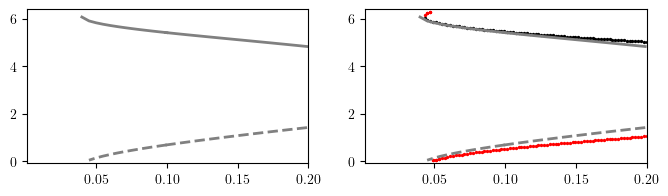

In [69]:
fig,axs = plt.subplots(1,2,figsize=(8,2))
kw_diagram = dict(a=a,b=b,eps_tup=etup,rhs=_redu_c2)
add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

for i in range(2):
    draw_quick_plot_f(axs[i],data_bs_list,a)
    draw_quick_plot_f(axs[i],data_bu_list,a,ls='--')

#### Monodromys min

In [70]:
# get min eps
es_min,phi0 = get_es_min(data_bs_list,data_bu_list)


eigenvalues_temp = []
es_min_temp = []
for i in range(5):
    ee = es_min+0.0005*i
    m1 = get_monodromy_full(ee,phi0[-1],a,b,mname=mname_list[i].format(b))
    eigenvalues_temp.append(m1.eigenvalues)
    es_min_temp.append(ee)

b_min_all.append(b)
eigenvalues_min_all.append(eigenvalues_temp)
e_vals_mono_min.append(es_min_temp)
#m1b = get_monodromy_full(es_min+.005,phi0[-1],a,b,mname=mname2.format(b))
# m1c = get_monodromy_full(es_min+.02,phi0[-1],a,b,mname=mname3.format(b))
#

#print(m1.eigenvalues)
#print(m1b.eigenvalues)

es_min,phi0 0.03999999999999995 6.065229370526596
phi init 6.065229370526596
Y [-0.10818594  0.22200759  0.08903806  0.40912093 -0.12806344  0.15202346  0.09235181  0.48636633  6.22695706]
mkdir ./data/thal2_21_b0=-0.04/
* Loading LC data...
self.T 6.226957114503936
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.0007542081328106975
es_min,phi0 0.04049999999999995 6.065229370526596
phi init 6.065229370526596
Y [-1.10916176e-01  2.30533141e-01  8.88094305e-02  3.96625519e-01 -5.82771542e-01  5.38842609e-01  9.84209461e-02  1.56277923e-03  6.22623649e+00]
mkdir ./data/thal2_21_b1=-0.04/
* Loading LC data...
self.T 6.2262365396790535
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.001510867439094095
es_min,phi0 0.04099999999999995 6.065229370526596
phi init 6.065229370526596
Y [-1.10888447e-01  2.25646019e-01  8.88157828e-02  4.02484569e-01 -5.81933659e-01  5.40409518e-01  9.84245227e-02  1.51962172e-03  6.22552991e+00]
mkdir

In [71]:
b_vals_full.append(b)

es = get_smallest_eps(data_bs_list)
eu = get_smallest_eps(data_bu_list)

e_vals_full.append(np.min([es,eu]))

es = get_largest_eps(data_bs_list)
eu = get_largest_eps(data_bu_list)

e_hi_full.append(np.max([es,eu]))

### b=-0.06

#### Branches eps stable

In [72]:
b=-.06
kw_b['recompute'] = False
kw_b['b'] = b

In [73]:
# in_dicts = [dict(phi0=phi0,eps_init=0.1,eps_final=0,deps=-.01) for phi0 in np.linspace(0,2*np.pi,20)]
in_dicts = [dict(phi0=5,eps_init=0.1,eps_final=0,deps=-.005),
            dict(phi0=5,eps_init=0.099,eps_final=0.2,deps=.005)]

In [74]:
data_bs_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_b)
    data_bs_list.append(dat)

phi init 5
phi init 5


In [75]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bs.format(b),hyp_inputs)

#### Branches eps unstable

In [76]:
kw_b['recompute'] = False
kw_b['b'] = b

In [77]:
# # get an initial condition for an unstable branch
# phis = np.linspace(5.8,6.1,30)
# for phi in phis:
#     dat,Yinit = follow_phase_diffs_u(**dict(phi0=phi,eps_init=0.02,eps_final=0,deps=-2),max_iter=100,return_point=True,**kw_b)

In [78]:
_,Yinit = follow_phase_diffs_u(**dict(phi0=.5,eps_init=0.1,eps_final=0,deps=-2),max_iter=100,return_point=True,**kw_b)

phi init 0.5
phase_diffs_u_init=0.5_nm=21_b=-0.06_ei=0.1_ef=0_de=-2.txt
phase_diffs_u_pt_init=0.5_nm=21_b=-0.06_ei=0.1_ef=0_de=-2.txt


In [79]:
#in_dicts = [dict(phi0=phi0,eps_init=0.01,eps_final=0.0,deps=-.01) for phi0 in np.linspace(4-1,4+1,10)]
in_dicts = [dict(phi0=.5,eps_init=0.1,eps_final=0,deps=-.005),
            dict(phi0=.5,eps_init=0.099,eps_final=0.2,deps=.01),
           ]

In [80]:
data_bu_list = []
# Y=Yinit
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs_u(use_point=Yinit,**in1,**kw_b)
    data_bu_list.append(dat)

phi init 0.5
phase_diffs_u_init=0.5_nm=21_b=-0.06_ei=0.1_ef=0_de=-0.005.txt
phase_diffs_u_pt_init=0.5_nm=21_b=-0.06_ei=0.1_ef=0_de=-0.005.txt
phi init 0.5
phase_diffs_u_init=0.5_nm=21_b=-0.06_ei=0.099_ef=0.2_de=0.01.txt
phase_diffs_u_pt_init=0.5_nm=21_b=-0.06_ei=0.099_ef=0.2_de=0.01.txt


In [81]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bu.format(b),hyp_inputs)

#### Plot combined 1 par

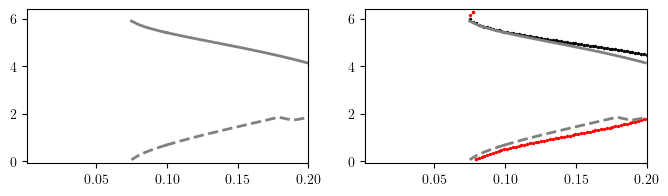

In [82]:
fig,axs = plt.subplots(1,2,figsize=(8,2))
kw_diagram = dict(a=a,b=b,eps_tup=etup,rhs=_redu_c2)
add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

for i in range(2):
    draw_quick_plot_f(axs[i],data_bs_list,a)
    draw_quick_plot_f(axs[i],data_bu_list,a,ls='--')

#### Monodromys min

In [83]:
# get min eps
es_min,phi0 = get_es_min(data_bs_list,data_bu_list)


eigenvalues_temp = []
es_min_temp = []
for i in range(5):
    ee = es_min+0.0005*i
    m1 = get_monodromy_full(ee,phi0[-1],a,b,mname=mname_list[i].format(b))
    eigenvalues_temp.append(m1.eigenvalues)
    es_min_temp.append(ee)

b_min_all.append(b)
eigenvalues_min_all.append(eigenvalues_temp)
e_vals_mono_min.append(es_min_temp)
#m1b = get_monodromy_full(es_min+.005,phi0[-1],a,b,mname=mname2.format(b))
# m1c = get_monodromy_full(es_min+.02,phi0[-1],a,b,mname=mname3.format(b))
#

#print(m1.eigenvalues)
#print(m1b.eigenvalues)

es_min,phi0 0.07499999999999998 5.8969814263466365
phi init 5.8969814263466365
Y [-1.13264509e-01  2.24107451e-01  8.55845124e-02  4.01423186e-01 -5.79642838e-01  5.43014327e-01  9.74636244e-02  1.42398923e-03  6.17899882e+00]
mkdir ./data/thal2_21_b0=-0.06/
* Loading LC data...
self.T 6.178998892375792
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.00812007240727222
es_min,phi0 0.07549999999999998 5.8969814263466365
phi init 5.8969814263466365
Y [-0.10812526  0.22794081  0.0861563   0.4011565  -0.16268399  0.11457063  0.09110191  0.52457596  6.178303  ]
mkdir ./data/thal2_21_b1=-0.06/
* Loading LC data...
self.T 6.178303063619222
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.00896358543342119
es_min,phi0 0.07599999999999998 5.8969814263466365
phi init 5.8969814263466365
Y [-0.10807952  0.22446957  0.08620173  0.40528709 -0.16756442  0.11093209  0.09104647  0.5282069   6.17761044]
mkdir ./data/thal2_21_b2=-0.06/
* Loadi

In [84]:
b_vals_full.append(b)

es = get_smallest_eps(data_bs_list)
eu = get_smallest_eps(data_bu_list)

e_vals_full.append(np.min([es,eu]))

es = get_largest_eps(data_bs_list)
eu = get_largest_eps(data_bu_list)

e_hi_full.append(np.max([es,eu]))

### b=-0.08

#### Branches eps stable

In [85]:
b=-.08
kw_b['recompute'] = False
kw_b['b'] = b

In [86]:
# in_dicts = [dict(phi0=phi0,eps_init=0.1,eps_final=0,deps=-.01) for phi0 in np.linspace(0,2*np.pi,20)]
in_dicts = [dict(phi0=5,eps_init=0.1,eps_final=0,deps=-.005),
            dict(phi0=5,eps_init=0.099,eps_final=0.2,deps=.005)]

In [87]:
data_bs_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_b)
    data_bs_list.append(dat)

phi init 5
phi init 5


In [88]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bs.format(b),hyp_inputs)

#### Branches eps unstable

In [89]:
kw_b['recompute'] = False
kw_b['b'] = b

In [90]:
# # get an initial condition for an unstable branch
# phis = np.linspace(5.8,6.1,30)
# for phi in phis:
#     dat,Yinit = follow_phase_diffs_u(**dict(phi0=phi,eps_init=0.02,eps_final=0,deps=-2),max_iter=100,return_point=True,**kw_b)

In [91]:
_,Yinit = follow_phase_diffs_u(**dict(phi0=1.5,eps_init=0.12,eps_final=0,deps=-2),max_iter=100,return_point=True,**kw_b)

phi init 1.5
phase_diffs_u_init=1.5_nm=21_b=-0.08_ei=0.12_ef=0_de=-2.txt
phase_diffs_u_pt_init=1.5_nm=21_b=-0.08_ei=0.12_ef=0_de=-2.txt


In [92]:
#in_dicts = [dict(phi0=phi0,eps_init=0.01,eps_final=0.0,deps=-.01) for phi0 in np.linspace(4-1,4+1,10)]
in_dicts = [dict(phi0=1.5,eps_init=0.1,eps_final=0,deps=-.002),
            dict(phi0=1.5,eps_init=0.09,eps_final=0.2,deps=.005),
           ]

In [93]:
data_bu_list = []
# Y=Yinit
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs_u(use_point=Yinit,**in1,**kw_b)
    data_bu_list.append(dat)

phi init 1.5
phase_diffs_u_init=1.5_nm=21_b=-0.08_ei=0.1_ef=0_de=-0.002.txt
phase_diffs_u_pt_init=1.5_nm=21_b=-0.08_ei=0.1_ef=0_de=-0.002.txt
phi init 1.5
phase_diffs_u_init=1.5_nm=21_b=-0.08_ei=0.09_ef=0.2_de=0.005.txt
phase_diffs_u_pt_init=1.5_nm=21_b=-0.08_ei=0.09_ef=0.2_de=0.005.txt


In [94]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bu.format(b),hyp_inputs)

#### Plot combined 1 par

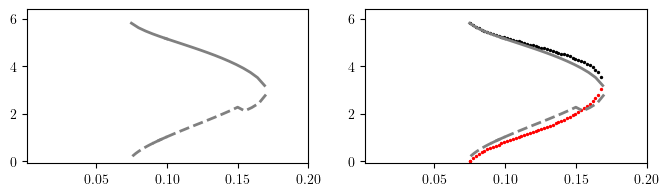

In [95]:
fig,axs = plt.subplots(1,2,figsize=(8,2))
kw_diagram = dict(a=a,b=b,eps_tup=etup,rhs=_redu_c2)
add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

for i in range(2):
    draw_quick_plot_f(axs[i],data_bs_list,a)
    draw_quick_plot_f(axs[i],data_bu_list,a,ls='--')

#### Monodromys min

In [96]:
# get min eps
es_min,phi0 = get_es_min(data_bs_list,data_bu_list)


eigenvalues_temp = []
es_min_temp = []
for i in range(5):
    ee = es_min+0.0005*i
    m1 = get_monodromy_full(ee,phi0[-1],a,b,mname=mname_list[i].format(b))
    eigenvalues_temp.append(m1.eigenvalues)
    es_min_temp.append(ee)

b_min_all.append(b)
eigenvalues_min_all.append(eigenvalues_temp)
e_vals_mono_min.append(es_min_temp)
#m1b = get_monodromy_full(es_min+.005,phi0[-1],a,b,mname=mname2.format(b))
# m1c = get_monodromy_full(es_min+.02,phi0[-1],a,b,mname=mname3.format(b))
#

#print(m1.eigenvalues)
#print(m1b.eigenvalues)

es_min,phi0 0.07399999999999998 0.09655181071172159
phi init 0.09655181071172159
Y [-0.10820437  0.21889422  0.08636371  0.41188    -0.16883499  0.10995631  0.09109336  0.52918837  6.18031427]
mkdir ./data/thal2_21_b0=-0.08/
* Loading LC data...
self.T 6.178920869928961
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.011802635863072094
es_min,phi0 0.07449999999999998 0.09655181071172159
phi init 0.09655181071172159
Y [-1.13073219e-01  2.33891355e-01  8.60760932e-02  3.89848881e-01 -5.78226301e-01  5.45790785e-01  9.74560578e-02  1.35093860e-03  6.17961510e+00]
mkdir ./data/thal2_21_b1=-0.08/
* Loading LC data...
self.T 6.178229920895744
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.012872768155339607
es_min,phi0 0.07499999999999998 0.09655181071172159
phi init 0.09655181071172159
Y [-1.13000576e-01  2.33765684e-01  8.61913775e-02  3.90086863e-01 -5.77486274e-01  5.47090611e-01  9.74270908e-02  1.31731777e-03  6.17892086e

#### Monodromys max

In [97]:
# get min eps
es_max,phi0 = get_es_max(data_bs_list,data_bu_list)


eigenvalues_temp = []
es_max_temp = []
for i in range(5):
    ee = es_max-0.0005*i
    m1 = get_monodromy_full(ee,phi0[-1],a,b,mname=mname_list[i].format(b),max_time=3000)
    eigenvalues_temp.append(m1.eigenvalues)
    es_max_temp.append(ee)

b_max_all.append(b)
eigenvalues_max_all.append(eigenvalues_temp)
e_vals_mono_max.append(es_max_temp)
#m1b = get_monodromy_full(es_max+.005,phi0[-1],a,b,mname=mname2.format(b))
# m1c = get_monodromy_full(es_max+.02,phi0[-1],a,b,mname=mname3.format(b))
#

#print(m1.eigenvalues)
#print(m1b.eigenvalues)

es_min,phi0 0.17000000000000007 2.8010282084157225
phi init 2.8010282084157225
period_est 6.040020133400444 time_est 2996.13998713329
iter, eps phase_diffs 0 0.17000000000000007 [3.0438727]                 

data1 shape [[0.17       3.02208913 3.0438727 ]]
Y [-1.04737708e-01  2.38853382e-01  9.60647192e-02  3.95629577e-01 -4.90211700e-01  6.24120635e-01  7.89035236e-02  1.06869218e-04  6.04360657e+00]
mkdir ./data/thal2_21_b0=-0.08/
* Loading LC data...
self.T 6.178920869928961
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.011802635863072094
es_min,phi0 0.16950000000000007 2.8010282084157225
phi init 2.8010282084157225
period_est 6.040020133400444 time_est 2996.42998809996
iter, eps phase_diffs 0 0.16950000000000007 [3.12703862]                

data1 shape [[0.1695     3.02208913 3.12703862]]
Y [-1.04641626e-01  2.33768218e-01  9.67956325e-02  4.01410845e-01 -4.92942032e-01  6.22919178e-01  7.92129921e-02  1.14565091e-04  6.04433540e+00]
mkdir ./data/

In [98]:
b_vals_full.append(b)

es = get_smallest_eps(data_bs_list)
eu = get_smallest_eps(data_bu_list)

e_vals_full.append(np.min([es,eu]))

es = get_largest_eps(data_bs_list)
eu = get_largest_eps(data_bu_list)

e_hi_full.append(np.max([es,eu]))

### b=-0.1

#### Branches eps stable

In [99]:
b=-.1
kw_b['recompute'] = False
kw_b['b'] = b

In [100]:
# in_dicts = [dict(phi0=phi0,eps_init=0.1,eps_final=0,deps=-.01) for phi0 in np.linspace(0,2*np.pi,20)]
in_dicts = [dict(phi0=5,eps_init=0.1,eps_final=0,deps=-.005),
            dict(phi0=5,eps_init=0.099,eps_final=0.2,deps=.005)]

In [101]:
data_bs_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_b)
    data_bs_list.append(dat)

phi init 5
phi init 5


In [102]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bs.format(b),hyp_inputs)

#### Branches eps unstable

In [103]:
kw_b['recompute'] = False
kw_b['b'] = b

In [104]:
# # get an initial condition for an unstable branch
# phis = np.linspace(5.8,6.1,30)
# for phi in phis:
#     dat,Yinit = follow_phase_diffs_u(**dict(phi0=phi,eps_init=0.02,eps_final=0,deps=-2),max_iter=100,return_point=True,**kw_b)

In [105]:
_,Yinit = follow_phase_diffs_u(**dict(phi0=1.5,eps_init=0.1,eps_final=0,deps=-2),max_iter=100,return_point=True,**kw_b)

phi init 1.5
phase_diffs_u_init=1.5_nm=21_b=-0.1_ei=0.1_ef=0_de=-2.txt
phase_diffs_u_pt_init=1.5_nm=21_b=-0.1_ei=0.1_ef=0_de=-2.txt


In [106]:
#in_dicts = [dict(phi0=phi0,eps_init=0.01,eps_final=0.0,deps=-.01) for phi0 in np.linspace(4-1,4+1,10)]
in_dicts = [dict(phi0=1.5,eps_init=0.1,eps_final=0,deps=-.002),
            dict(phi0=1.5,eps_init=0.099,eps_final=0.2,deps=.002),
           ]

In [107]:
data_bu_list = []
# Y=Yinit
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs_u(use_point=Yinit,**in1,**kw_b)
    data_bu_list.append(dat)

phi init 1.5
phase_diffs_u_init=1.5_nm=21_b=-0.1_ei=0.1_ef=0_de=-0.002.txt
phase_diffs_u_pt_init=1.5_nm=21_b=-0.1_ei=0.1_ef=0_de=-0.002.txt
phi init 1.5
phase_diffs_u_init=1.5_nm=21_b=-0.1_ei=0.099_ef=0.2_de=0.002.txt
phase_diffs_u_pt_init=1.5_nm=21_b=-0.1_ei=0.099_ef=0.2_de=0.002.txt
iter, eps phase_diffs 0 0.099 [1.45389273]                              
iter, eps phase_diffs 1 0.101 [1.51613772]                              
iter, eps phase_diffs 2 0.10300000000000001 [1.57846373]                
iter, eps phase_diffs 3 0.10500000000000001 [1.64087093]                
iter, eps phase_diffs 4 0.10700000000000001 [1.69981871]                
iter, eps phase_diffs 5 0.10900000000000001 [1.77002677]                
iter, eps phase_diffs 6 0.11100000000000002 [1.83678109]                
iter, eps phase_diffs 7 0.11300000000000002 [1.90362258]                
iter, eps phase_diffs 8 0.11500000000000002 [1.97119539]                
iter, eps phase_diffs 9 0.11700000000000002 [2.05056211] 

In [108]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bu.format(b),hyp_inputs)

#### Plot combined 1 par

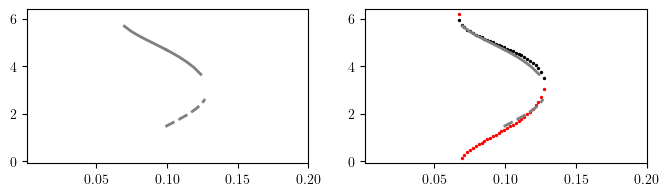

In [109]:
fig,axs = plt.subplots(1,2,figsize=(8,2))
kw_diagram = dict(a=a,b=b,eps_tup=etup,rhs=_redu_c2)
add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

for i in range(2):
    draw_quick_plot_f(axs[i],data_bs_list,a)
    draw_quick_plot_f(axs[i],data_bu_list,a,ls='--')

#### Monodromys min

In [110]:
# get min eps
es_min,phi0 = get_es_min(data_bs_list,data_bu_list)


eigenvalues_temp = []
es_min_temp = []
for i in range(5):
    ee = es_min+0.0005*i
    m1 = get_monodromy_full(ee,phi0[-1],a,b,mname=mname_list[i].format(b))
    eigenvalues_temp.append(m1.eigenvalues)
    es_min_temp.append(ee)

b_min_all.append(b)
eigenvalues_min_all.append(eigenvalues_temp)
e_vals_mono_min.append(es_min_temp)
#m1b = get_monodromy_full(es_min+.005,phi0[-1],a,b,mname=mname2.format(b))
# m1c = get_monodromy_full(es_min+.02,phi0[-1],a,b,mname=mname3.format(b))
#

#print(m1.eigenvalues)
#print(m1b.eigenvalues)

es_min,phi0 0.06999999999999998 5.681033171558772
phi init 5.681033171558772
period_est 6.190006190006191 time_est 9996.319996319997
iter, eps phase_diffs 0 0.06999999999999998 [5.6940732]                 

data1 shape [[0.07       3.09309122 5.6940732 ]]
Y [-0.10765888  0.23504077  0.08784681  0.39353967 -0.20706546  0.08990364  0.09080788  0.52791815  6.18566616]
mkdir ./data/thal2_21_b0=-0.1/
* Loading LC data...
self.T 6.189835878401323
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.00698895398553478
es_min,phi0 0.07049999999999998 5.681033171558772
phi init 5.681033171558772
period_est 6.190006190006191 time_est 9995.229995229996
iter, eps phase_diffs 0 0.07049999999999998 [5.66543358]                

data1 shape [[0.0705     3.09209119 5.66543358]]
Y [-0.10744359  0.22780399  0.08794075  0.40216616 -0.21613405  0.08669888  0.09070531  0.51517811  6.18498152]
mkdir ./data/thal2_21_b1=-0.1/
* Loading LC data...
self.T 6.189120427290122
loaded coupl

#### Monodromys max

In [111]:
# get min eps
es_max,phi0 = get_es_max(data_bs_list,data_bu_list)


eigenvalues_temp = []
es_max_temp = []
for i in range(5):
    ee = es_max-0.0005*i
    m1 = get_monodromy_full(ee,phi0[-1],a,b,mname=mname_list[i].format(b),max_time=3000)
    eigenvalues_temp.append(m1.eigenvalues)
    es_max_temp.append(ee)

b_max_all.append(b)
eigenvalues_max_all.append(eigenvalues_temp)
e_vals_mono_max.append(es_max_temp)
#m1b = get_monodromy_full(es_max+.005,phi0[-1],a,b,mname=mname2.format(b))
# m1c = get_monodromy_full(es_max+.02,phi0[-1],a,b,mname=mname3.format(b))
#

#print(m1.eigenvalues)
#print(m1b.eigenvalues)

es_min,phi0 0.12700000000000003 2.6138710529867737
phi init 2.6138710529867737
period_est 6.090020300067668 time_est 2995.939986466621
iter, eps phase_diffs 0 0.12700000000000003 [3.38785065]                

data1 shape [[0.127      3.04908993 3.38785065]]
Y [-0.11759351  0.22691965  0.0980921   0.39408611 -0.57983368  0.17374115  0.07766909  0.07727344  6.09965768]
mkdir ./data/thal2_21_b0=-0.1/
* Loading LC data...
self.T 6.189835878401323
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.00698895398553478
es_min,phi0 0.12650000000000003 2.6138710529867737
phi init 2.6138710529867737
period_est 6.090020300067668 time_est 2996.5099883666276
iter, eps phase_diffs 0 0.12650000000000003 [3.44442158]                

data1 shape [[0.1265     3.05008995 3.44442158]]
Y [-0.11709417  0.23167378  0.0983119   0.38875543 -0.57574407  0.16834026  0.07784837  0.08145175  6.10078247]
mkdir ./data/thal2_21_b1=-0.1/
* Loading LC data...
self.T 6.189120427290122
loaded 

In [112]:
b_vals_full.append(b)

es = get_smallest_eps(data_bs_list)
eu = get_smallest_eps(data_bu_list)

e_vals_full.append(np.min([es,eu]))

es = get_largest_eps(data_bs_list)
eu = get_largest_eps(data_bu_list)

e_hi_full.append(np.max([es,eu]))

# Two parameter full

In [113]:
# fname_raw = 'thal2r_{}{}_2par_fixed.dat'
# data = np.loadtxt('../bifdat_2par/'+fname_raw.format(a._n[1],a._m[1]))

fname_raw = 'thal2_{}{}_o2_pos.dat'
data = np.loadtxt('../v2_bifdat_2par/redu/'+fname_raw.format(a._n[1],a._m[1]))

fname_raw = 'thal2_{}{}_o2_neg.dat'
data2 = np.loadtxt('../v2_bifdat_2par/redu/'+fname_raw.format(a._n[1],a._m[1]))

(-0.1, 0.05)

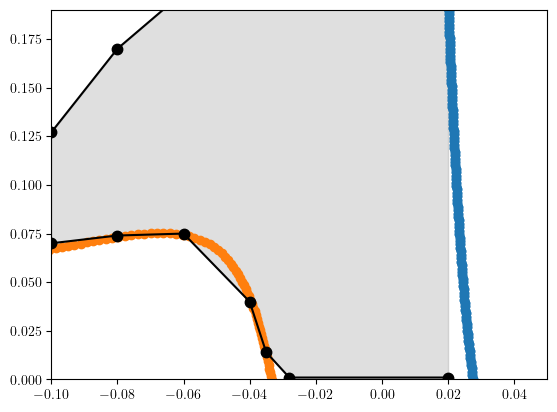

In [114]:
fig,axs = plt.subplots()
axs.fill_between(b_vals_full,e_vals_full,e_hi_full,color='gray',alpha=.25)
axs.plot(b_vals_full,e_vals_full,marker='.',color='k',markersize=15)
axs.plot(b_vals_full,e_hi_full,marker='.',color='k',markersize=15)

# split_idx = np.where(np.isnan(data[:,0]))[0][0]

# br1 = data[:split_idx]
# br2 = data[split_idx+1:]

# axs.plot(br1[:,0],br1[:,1],color='r',marker='.')
# axs.plot(br2[:,0],br2[:,1],color='r',marker='.')

axs.scatter(data[:,1],data[:,0])
axs.scatter(data2[:,1],data2[:,0])

axs.set_ylim(0,.19)
axs.set_xlim(-.1,.05)

In [115]:
fname_lo = '../v2_bifdat_2par/full/thal2_2par_lo_{}{}.dat'.format(a._n[1],a._m[1])
fname_hi = '../v2_bifdat_2par/full/thal2_2par_hi_{}{}.dat'.format(a._n[1],a._m[1])

arr_lo = np.zeros([len(b_vals_full),2])
arr_hi = np.zeros([len(b_vals_full),2])

arr_lo[:,0] = b_vals_full
arr_lo[:,1] = e_vals_full

arr_hi[:,0] = b_vals_full
arr_hi[:,1] = e_hi_full

np.savetxt(fname_lo,arr_lo)
np.savetxt(fname_hi,arr_hi)

# Eigenvalue Convergence Plot

## Min

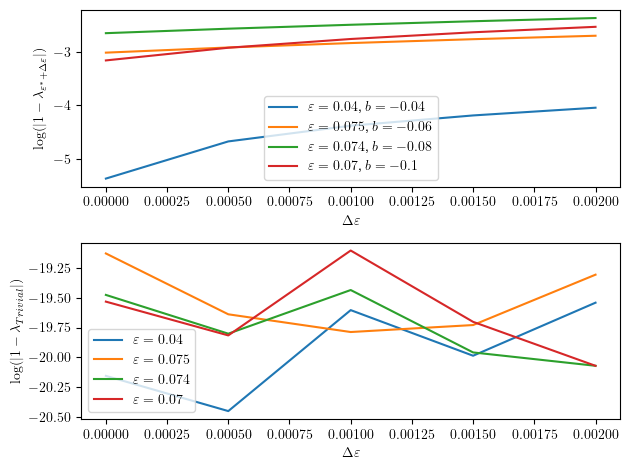

In [118]:
fig,axs = plt.subplots(2,1)

eps_values = np.arange(0,+0.0005*5,.0005)
skipn = 1

for j in range(len(eigenvalues_min_all[::skipn])):
    nn = len(eigenvalues_min_all[::skipn][j])

    at_eigen = []
    near_eigen = []
    
    for i in range(nn):
        eigenval = np.array(eigenvalues_min_all[::skipn][j][i])
        
        min1 = np.argsort(np.abs(eigenval-1))[:2]
        periodic1,bif1 = eigenval[min1]
        
        at_eigen.append(periodic1)
        near_eigen.append(bif1)

    
    ee = e_vals_mono_min[::skipn][j]
    e0 = ee[0]
    de = ee - e0
    
    axs[0].plot(eps_values,np.log(np.abs(1-np.array(near_eigen))),label=r'$\varepsilon='+str(np.round(e0,3))+r'$, ' +r'$b='+str(b_min_all[j])+r'$')
    axs[1].plot(eps_values,np.log(np.abs(1-np.array(at_eigen))),label=r'$\varepsilon='+str(np.round(e0,3))+r'$')
    #axs[1].plot(lc_list2,label='Near Bifurcation')

    axs[0].legend()
    axs[1].legend()

    axs[0].set_xlabel(r'$\Delta\varepsilon$')
    axs[1].set_xlabel(r'$\Delta\varepsilon$')
    #axs[1].set_xlabel('Point')
    
    axs[0].set_ylabel(r'$\log(|1 - \lambda_{\varepsilon^*+\Delta\varepsilon}|)$')
    axs[1].set_ylabel(r'$\log(|1-\lambda_{Trivial}|)$')

    plt.tight_layout()
    plt.savefig('../figs/supp_convergence_thal2_min_{}{}.png'.format(a._n[1],a._m[1]))

## Max

In [ ]:
fig,axs = plt.subplots(2,1)

#es_min+.0001+0.0005*i
#ee = es_max-.0001-0.0005*i
eps_values = np.arange(-0.0001,0.0001-0.0005*5,-.0005)
skipn = 1

for j in range(len(eigenvalues_max_all[::skipn])):
    nn = len(eigenvalues_max_all[::skipn][j])

    at_eigen = []
    near_eigen = []
    
    for i in range(nn):
        eigenval = np.array(eigenvalues_max_all[::skipn][j][i])
        
        max1 = np.argsort(np.abs(eigenval-1))[:2]
        periodic1,bif1 = eigenval[max1]
        
        at_eigen.append(periodic1)
        near_eigen.append(bif1)

    ee = e_vals_mono_max[::skipn][j]
    e0 = ee[0]
    de = ee - e0
    
    axs[0].plot(eps_values,np.log(np.abs(1-np.array(near_eigen))),label=r'$\varepsilon='+str(np.round(e0,3))+r'$, ' +r'$b='+str(b_max_all[j])+r'$')
    axs[1].plot(eps_values,np.log(np.abs(1-np.array(at_eigen))),label=r'$\varepsilon='+str(np.round(e0,3))+r'$')
    #axs[1].plot(lc_list2,label='Near Bifurcation')

    axs[0].legend()
    axs[1].legend()

    axs[0].set_xlabel(r'$\Delta\varepsilon$')
    axs[1].set_xlabel(r'$\Delta\varepsilon$')
    #axs[1].set_xlabel('Point')
    
    axs[0].set_ylabel(r'$\log(|1 - \lambda_{\varepsilon^*-\Delta\varepsilon}|)$')
    axs[1].set_ylabel(r'$\log(|1-\lambda_{Trivial}|)$')

    plt.tight_layout()
    plt.savefig('../figs/supp_convergence_thal2_max_{}{}.png'.format(a._n[1],a._m[1]))